In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timewarp_lib.load_model as lm
import timewarp_lib.train_utils as tu
import torch
import pandas as pd
import json
import numpy as np
import matplotlib
import torch.nn as nn

/home/travers/miniconda3/envs/timewarpvae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cmap = plt.get_cmap("viridis")

In [3]:

####clean_model_dirs = ["../results/overnight/20230921-093159.705744/savedmodel"] # TenDTWModel



In [4]:
import matplotlib
font = {        'size'   : 22}

matplotlib.rc('font', **font)

In [5]:
datatype = "train"
dtype=torch.float
device="cpu"
batch_size=100
training_data_timing_noise=0

dataName = "../data/trainTest2DLetterARescaled.npz"
# the datafile has information on how the data was cleaned
# the learned/applied model is on clean data
# so we need to convert back to trajectory data
loaded_data_dict = np.load(dataName)

ydata = torch.tensor(loaded_data_dict[datatype],dtype=dtype).to(device)
np_ydata = ydata.detach().cpu().numpy()
num_trajs, numts, traj_channels = ydata.shape
tdata = torch.tensor(np.linspace(0,1,numts),dtype=dtype).to(device).expand(num_trajs,numts).unsqueeze(2)

In [6]:
ixs=(10,)

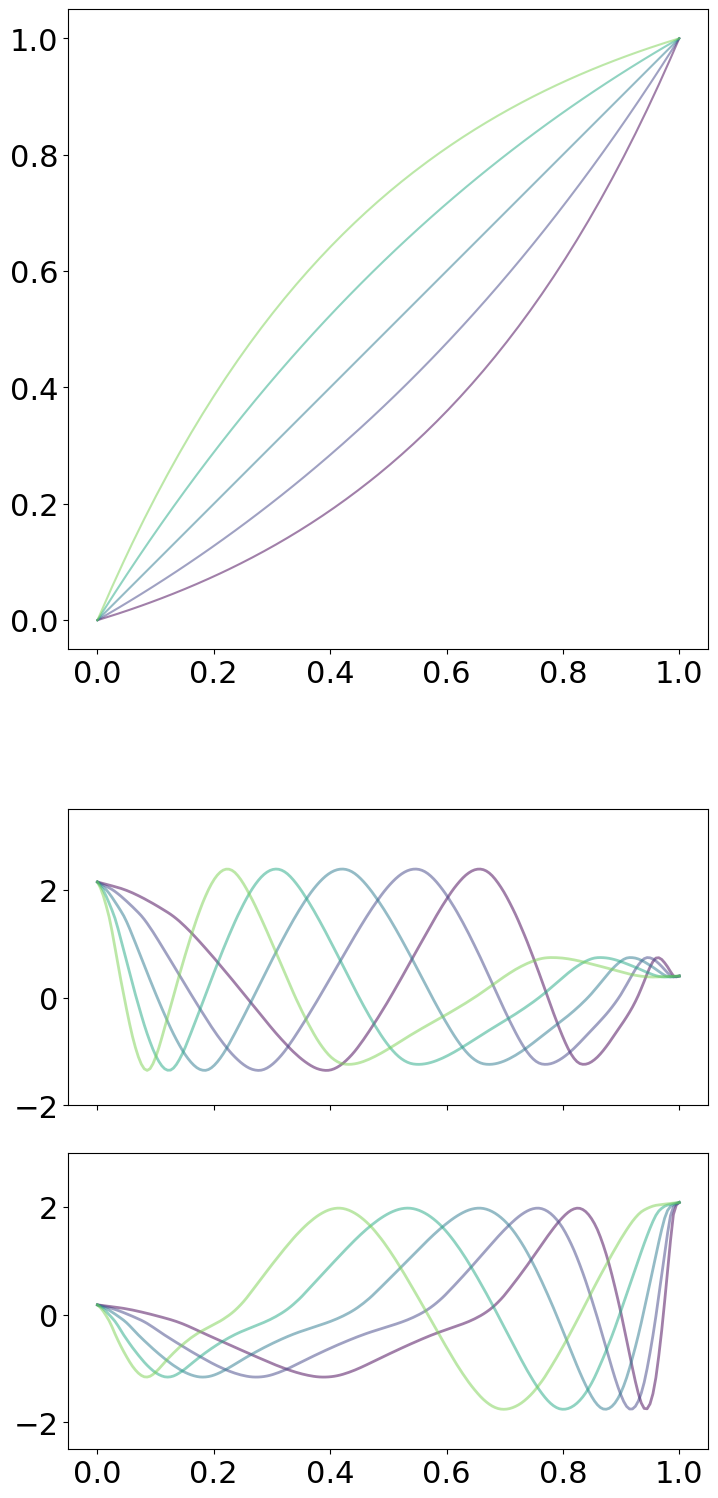

In [13]:
saved_model_dir = "../results/rescaled/20231011-003229.166126/savedmodel"
pose_mean = loaded_data_dict["pose_mean"]
pose_scaling = loaded_data_dict["pose_scaling"]

modelApplier = lm.LoadedModel(saved_model_dir)
modeldatafileobj = np.load(f"{saved_model_dir}/saved_model_info.npz",allow_pickle=True)
modeldata = {key : (modeldatafileobj[key] if key != "initialization_function" else True) for key in modeldatafileobj.keys()}
num_timesteps = 200
num_channels = 2
latent_dim = (int)(modeldata["latent_dim"])

hi=modelApplier.model

embeds_torch,_ = hi.encoder.encode(ydata[ixs,],tdata[ixs,])
embeds = embeds_torch.detach().cpu().numpy()


f = plt.figure(figsize=(8,16))
smallht = 0.37/2
ax1 = f.add_axes([0.1, 0.6, 0.8, 0.4])  # add the left Axes
ax2 = f.add_axes([0.1, 0.1, 0.8, smallht])  # add the bottomright Axes
ax3 = f.add_axes([0.1, 0.5-smallht, 0.8, smallht])  # add the topright Axes
for i,val in enumerate(np.linspace(-1,1,5)):
    canonical_ts = torch.tensor(np.array(np.linspace(0,1,num_timesteps).reshape(1,-1,1)),dtype=torch.float)
    ts = canonical_ts.detach()[0]
    time_transform_coeffs = nn.LogSoftmax(dim=1)(torch.tensor(np.linspace(val,-val,50),dtype=torch.float).reshape(1,-1))+np.log(50)
    # super easy way to take reasonable coefficients but then scale nicely. We like this
    # because the scaling penalty (based on time_transform_coeffs) doesn't need to change. yay.
    scaled_ts_torch = hi.scalar_timewarper.monotonic_applier.batch_apply_monotonic_transformation(time_transform_coeffs,canonical_ts)
    scaled_ts = scaled_ts_torch
    #plt.plot(scaled_ts.detach().flatten())
    newtime_trajs = hi.decoder.decode(embeds_torch, scaled_ts).detach().numpy()[0]

    #plt.plot(ts.flatten(),newtime_trajs[:,0])
    smallht = 0.37/2
    
    alpha = 0.5
    threeixs = (0,1,-1)
    legend_lines = []
    shapes =["+",None,"x"]
    ax1.plot(ts.flatten(),scaled_ts.flatten(),c=cmap(i/5),alpha=alpha)
    for pltax, axis, axisname in ((ax2,0,"X"),(ax3, 1,"Y")):
        pltax.plot(ts,newtime_trajs[:,axis],c=cmap(i/5),
                     linewidth=2 ,
                     alpha=alpha)
        if axis==1:
            pltax.set_xticklabels([])
            pltax.set_ylim(-2,3.5)
        else:
            pltax.set_ylim(-2.5,3)

            
f.savefig("VaryingTimingUsingTimewarper.pdf")